In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import time

In [3]:
data_dir = '../data/train/'

train = pd.read_csv(data_dir + 'train_ratings.csv')
titles = pd.read_csv(data_dir + 'titles.tsv', sep='\t')
directors = pd.read_csv(data_dir + 'directors.tsv', sep='\t')
genres = pd.read_csv(data_dir + 'genres.tsv', sep='\t')
writers = pd.read_csv(data_dir + 'writers.tsv', sep='\t')
years = pd.read_csv(data_dir + 'years.tsv', sep='\t')
train.head()

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


train에서 feature 종류

In [4]:
train.nunique()

user      31360
item       6807
time    5074973
dtype: int64

user별 item 수

In [5]:
train.groupby('user').item.count().sort_values()

user
53188       16
68606       19
105578      22
128756      28
11211       32
          ... 
91349     1795
32514     1830
24219     1842
54465     1980
8405      2912
Name: item, Length: 31360, dtype: int64

time feature를 알아볼 수 있도록 변경

In [6]:
train['timestamp'] = train['time'].apply(lambda x : time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
train['year'] = train['time'].apply(lambda x : int(time.strftime('%Y', time.localtime(x))))
train['month'] = train['time'].apply(lambda x : int(time.strftime('%m', time.localtime(x))))
train['day'] = train['time'].apply(lambda x : int(time.strftime('%d', time.localtime(x))))
train['hour'] = train['time'].apply(lambda x : int(time.strftime('%H', time.localtime(x))))
train['minute'] = train['time'].apply(lambda x : int(time.strftime('%M', time.localtime(x))))
train['second'] = train['time'].apply(lambda x : int(time.strftime('%S', time.localtime(x))))
train.head()

,user,item,time,timestamp,year,month,day,hour,minute,second
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,4,2,9
1,11,170,1230782534,2009-01-01 04:02:14,2009,1,1,4,2,14
2,11,531,1230782539,2009-01-01 04:02:19,2009,1,1,4,2,19
3,11,616,1230782542,2009-01-01 04:02:22,2009,1,1,4,2,22
4,11,2140,1230782563,2009-01-01 04:02:43,2009,1,1,4,2,43


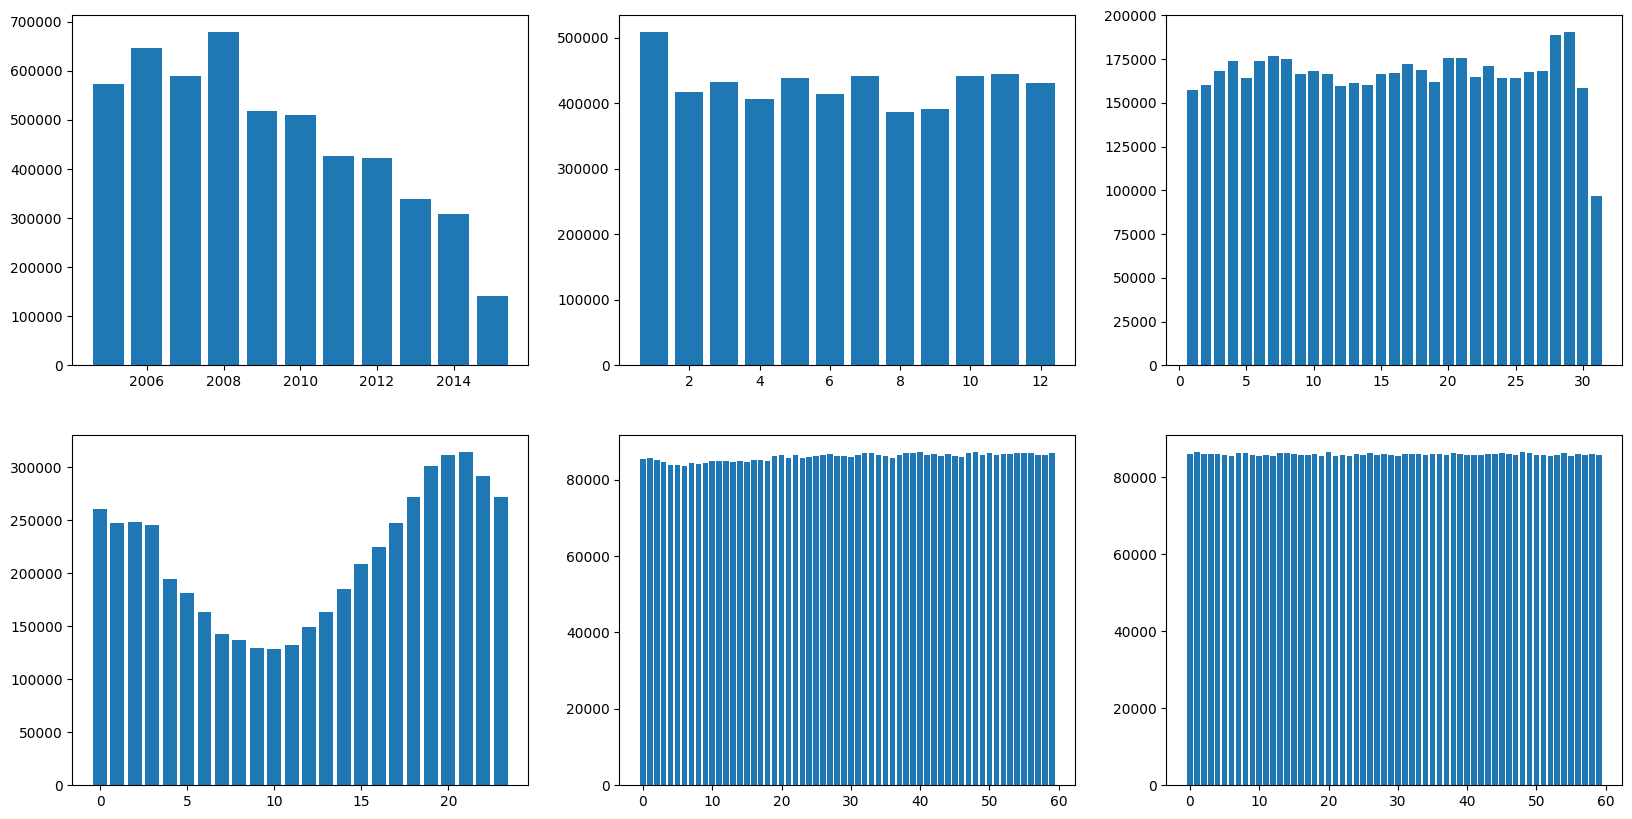

In [7]:
plt.figure(figsize=(20,10))
index = 1
for col in ['year', 'month', 'day', 'hour', 'minute', 'second'] :
    data = train[col].value_counts().sort_index()
    plt.subplot(2, 3, index)
    plt.bar(data.index, data.values)
    
    index += 1


item의 title 중복 확인

In [8]:
titles.groupby('item').title.nunique().max()

1

In [9]:
train = pd.merge(train, titles, on='item')
train.head()

,user,item,time,timestamp,year,month,day,hour,minute,second,title
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,4,2,9,Planet of the Apes (2001)
1,189,4643,1302945016,2011-04-16 09:10:16,2011,4,16,9,10,16,Planet of the Apes (2001)
2,294,4643,1288437662,2010-10-30 11:21:02,2010,10,30,11,21,2,Planet of the Apes (2001)
3,383,4643,1261996844,2009-12-28 10:40:44,2009,12,28,10,40,44,Planet of the Apes (2001)
4,421,4643,1190624541,2007-09-24 09:02:21,2007,9,24,9,2,21,Planet of the Apes (2001)


item의 year 중복 확인

In [36]:
years.nunique()

item          6799
movie_year      93
dtype: int64

In [10]:
years.groupby('item').year.nunique().max()

1

In [11]:
years.columns = ['item', 'movie_year']
train = pd.merge(train, years, on='item')
train.head()

,user,item,time,timestamp,year,month,day,hour,minute,second,title,movie_year
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,4,2,9,Planet of the Apes (2001),2001
1,189,4643,1302945016,2011-04-16 09:10:16,2011,4,16,9,10,16,Planet of the Apes (2001),2001
2,294,4643,1288437662,2010-10-30 11:21:02,2010,10,30,11,21,2,Planet of the Apes (2001),2001
3,383,4643,1261996844,2009-12-28 10:40:44,2009,12,28,10,40,44,Planet of the Apes (2001),2001
4,421,4643,1190624541,2007-09-24 09:02:21,2007,9,24,9,2,21,Planet of the Apes (2001),2001


<BarContainer object of 93 artists>

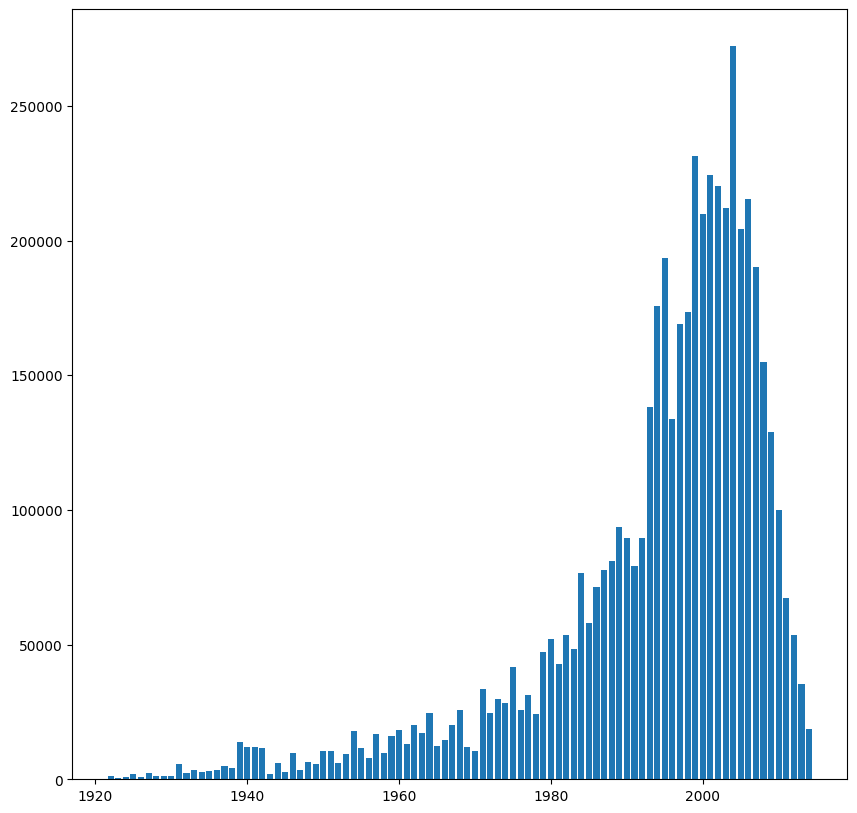

In [12]:
data = train.movie_year.value_counts().sort_index()
plt.figure(figsize=(10,10))
plt.bar(data.index, data.values)

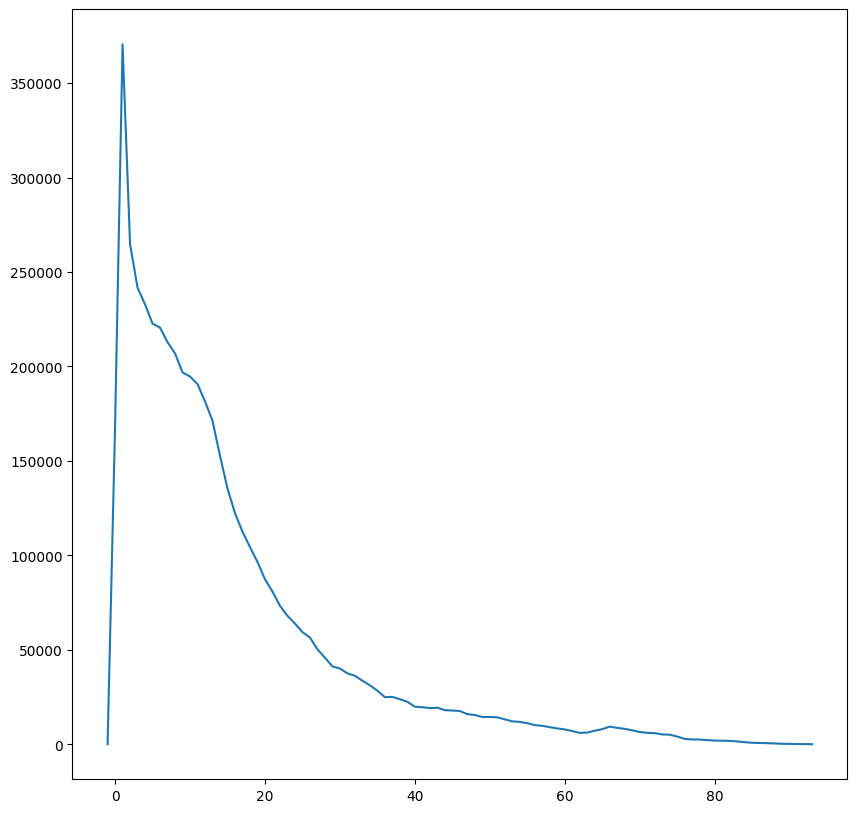

In [13]:
train['long'] = train[['year', 'movie_year']].apply(lambda x : x[0] - x[1], axis=1)
plt.figure(figsize=(10,10))
plt.plot(train.groupby('long').item.count())

item의 director 중복 확인

In [35]:
directors.nunique()

item        5503
director    1340
dtype: int64

In [14]:
director_counts = directors.groupby('item').director.nunique().sort_values()
director_counts

item
1         1
26163     1
26158     1
26151     1
26150     1
         ..
7502      7
71823     7
27002     8
1282     10
50912    14
Name: director, Length: 5503, dtype: int64

In [15]:
ones = director_counts[director_counts == 1].index

f"{len(ones) / train.item.nunique() * 100: .2f}%, {len(train[train.item.isin(ones)].item) / len(train.item) * 100 : .2f}%"

' 76.78%,  86.92%'

In [32]:
rating_direct = pd.merge(train, directors, on='item').groupby('director').item.count().sort_values(ascending=False)
rating_direct

director
nm0000229    130434
nm0000233     81880
nm0634240     65526
nm0000709     63374
nm0001392     60938
              ...  
nm0070159       103
nm0788454        99
nm0001674        97
nm0443181        96
nm0921631        96
Name: item, Length: 1339, dtype: int64

In [33]:
direct_count = directors.groupby('director').item.count().sort_values(ascending=False)
direct_count

director
nm0000095    44
nm0000033    33
nm0000142    31
nm0000229    29
nm0000217    26
             ..
nm0404606     2
nm0405605     2
nm0410139     2
nm0410769     2
nm9054338     2
Name: item, Length: 1340, dtype: int64

In [34]:
for i in rating_direct.index :
    print(f"{i} : {rating_direct[i] / direct_count[i]}")

nm0000229 : 4497.724137931034
nm0000233 : 7443.636363636364
nm0634240 : 7280.666666666667
nm0000709 : 4224.933333333333
nm0001392 : 4352.714285714285
nm0000217 : 2127.0384615384614
nm0001054 : 3199.705882352941
nm0000116 : 7660.571428571428
nm0000399 : 5338.5
nm0000631 : 2797.8947368421054
nm0001053 : 3301.3125
nm0000318 : 3027.6470588235293
nm0000040 : 4186.583333333333
nm0000416 : 3452.6666666666665
nm0000338 : 2781.285714285714
nm0000165 : 1895.8
nm0000033 : 1116.939393939394
nm0001661 : 2477.285714285714
nm0881279 : 8460.0
nm0001741 : 4217.375
nm0000184 : 5509.5
nm0000142 : 1060.4193548387098
nm0905154 : 5292.666666666667
nm0905152 : 5292.666666666667
nm0001752 : 1363.5652173913043
nm0001532 : 3389.5555555555557
nm0594503 : 2645.5454545454545
nm0001104 : 7229.0
nm0000600 : 2208.076923076923
nm0000965 : 2803.9
nm0893659 : 2976.8888888888887
nm0005124 : 5271.6
nm0004056 : 6435.75
nm0001060 : 2338.0
nm0011470 : 6307.0
nm0001675 : 1781.4285714285713
nm0000095 : 549.6590909090909
nm0796

writers

In [37]:
writers.nunique()

item      5648
writer    2989
dtype: int64

In [16]:
writer_counts = writers.groupby('item').writer.nunique().sort_values()
writer_counts

item
5463      1
6567      1
6583      1
6586      1
6592      1
         ..
48322    19
364      21
2687     21
783      23
1907     24
Name: writer, Length: 5648, dtype: int64

In [17]:
ones = writer_counts[writer_counts == 1].index

f"{len(ones) / train.item.nunique() * 100: .2f}%, {len(train[train.item.isin(ones)].item) / len(train.item) * 100 : .2f}%"

' 39.12%,  35.49%'

genres

In [38]:
genres.nunique()

item     6807
genre      18
dtype: int64

In [22]:
rating_genre = pd.merge(train, genres, on='item').groupby('genre').item.count().sort_values()
rating_genre

genre
Film-Noir        70402
Documentary      90050
Western          95374
Musical         199635
War             307061
Horror          342967
Animation       370761
Children        397929
Mystery         493005
Fantasy         616861
Sci-Fi          857668
Romance         893773
Crime          1013639
Adventure      1203022
Thriller       1435678
Action         1504641
Comedy         1718388
Drama          2510670
Name: item, dtype: int64

In [23]:
genres_count = genres.groupby('genre').item.count().sort_values()
genres_count

genre
Film-Noir        97
Western         139
Musical         282
Documentary     323
War             346
Animation       355
Children        432
Mystery         471
Fantasy         557
Horror          602
Sci-Fi          653
Adventure       891
Crime           924
Action         1246
Romance        1251
Thriller       1466
Comedy         2408
Drama          3490
Name: item, dtype: int64

In [25]:
for i in rating_genre.index :
    print(f"{i} : {rating_genre[i] / genres_count[i]}")

Film-Noir : 725.7938144329897
Documentary : 278.79256965944273
Western : 686.1438848920864
Musical : 707.9255319148937
War : 887.4595375722544
Horror : 569.7126245847176
Animation : 1044.3971830985915
Children : 921.1319444444445
Mystery : 1046.71974522293
Fantasy : 1107.4703770197486
Sci-Fi : 1313.427258805513
Romance : 714.4468425259793
Crime : 1097.0119047619048
Adventure : 1350.1930415263748
Thriller : 979.3165075034107
Action : 1207.5770465489566
Comedy : 713.6162790697674
Drama : 719.3896848137535
